In [2]:
import warnings
warnings.filterwarnings("ignore")

# General-purpose libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# Dash for web apps
from dash import Dash, dcc, html, Input, Output
from jupyter_dash import JupyterDash

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.inspection import PartialDependenceDisplay

# Boosting models
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

# Statistical tools
from scipy.stats import linregress

# SHAP for interpretability
import shap

# Joblib for saving the Models
import joblib

In [3]:
def merge_datasets(df, value):
    if value == 'train':
        df = df.merge(train_cxid, on="customer_id", how="left")
    elif value == 'test':
        df = df.merge(test_cxid, on="customer_id", how="left")
    return df

In [4]:
def compute_slope(row):
    day_cols = [f"Day_{i}" for i in range(1, 61)]
    
    try:
        usage_values = np.array(row[day_cols].values, dtype=float)
    except KeyError:
        return 0  # Day columns missing
    
    if len(usage_values) != 60:
        return 0

    if np.isnan(usage_values).any() or np.all(usage_values == 0) or len(np.unique(usage_values)) == 1:
        return 0  # Avoid NaNs, all-zero, or flat signals

    days = np.arange(1, 61)
    slope, _, _, _, _ = linregress(days, usage_values)
    return slope

In [5]:
def engineer_features(df):
    # Day columns for feature engineering:
    day_cols = [f"Day_{i}" for i in range(1, 61)]   # Observing for the first 60 days
    usage_data = df[day_cols].astype(float).copy()
        
    # trend based features:
    # 1. Exponential Moving Average (ema):
    df["ema_7d"] = usage_data.T.ewm(span=7, adjust=False).mean().T.iloc[:, -1]
    df["ema_14d"] = usage_data.T.ewm(span=14, adjust=False).mean().T.iloc[:, -1]
    df["ema_30d"] = usage_data.T.ewm(span=30, adjust=False).mean().T.iloc[:, -1]

    # 2. Standard Deviation (std):
    df["std_7d"] = usage_data.iloc[:, 0:7].std(axis=1)
    df["std_14d"] = usage_data.iloc[:, 0:14].std(axis=1)
    df["std_30d"] = usage_data.iloc[:, 0:30].std(axis=1)

    # behavioral features:
    df["drop_trend"] = usage_data.iloc[:, -30:].mean(axis=1) - usage_data.iloc[:, -60:-30].mean(axis=1)
    df["zero_days"] = (usage_data == 0).sum(axis=1)

    # last active day:
    last_active_series = usage_data.apply(lambda row: row[::-1].to_numpy().nonzero()[0], axis=1)
    df["last_active"] = last_active_series.apply(lambda x: 61 - x[0] if len(x) > 0 else 61)

    # aggregation features:
    df["total_usage"] = usage_data.sum(axis=1)
    df["average_usage"] = usage_data.mean(axis=1)
    df["max_usage"] = usage_data.max(axis=1)
    df["min_usage"] = usage_data.min(axis=1)
    df["percentile_25"] = usage_data.quantile(0.25, axis=1)
    df["percentile_75"] = usage_data.quantile(0.75, axis=1)

    # usage features:
    df["usage_cv"] = usage_data.std(axis=1) / (usage_data.mean(axis=1) + 1e-3)
    df["usage_slope"] = df.apply(compute_slope, axis=1)
    df["usage_variance"] = usage_data.var(axis=1)

    return df

In [6]:
def add_expected_tenure(df):
    day_cols = [f"Day_{i}" for i in range(1, 91)]
    def expected_tenure(row):
        usage = row[day_cols].values
        non_zero = np.where(usage > 0)[0]
        return non_zero[-1] + 1 if len(non_zero) > 0 else 0
    df["expected_tenure"] = df.apply(expected_tenure, axis=1)
    return df

In [7]:
def preprocess_data(df):
    # Dropping customer_id due to no further use:
    if "customer_id" in df.columns:
        df.drop(columns=["customer_id"], inplace=True)

    # Filling Null values dynamically based on data type:
    if df.isnull().sum().sum() > 0:
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64', 'int32']:
                df[col].fillna(df[col].median(), inplace=True)
            elif df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)

    # Dropping the day1-90 columns
    day_cols = [f"Day_{i}" for i in range(1,91)]
    df.drop(columns=[col for col in day_cols if col in df.columns], inplace=True)

    # Rare label handling in usage_type:
    if "usage_type" in df.columns:
        rare_threshold = 0.01
        usage_counts = df["usage_type"].value_counts(normalize=True)
        rare_usages = usage_counts[usage_counts < rare_threshold].index
        df["usage_type"] = df["usage_type"].apply(lambda x: "other" if x in rare_usages else x)

        # One-hot encode usage_type
        df = pd.get_dummies(df, columns=["usage_type"], drop_first=True)

    # Convert boolean columns to integer/numerical type:
    for col in df.select_dtypes(include="bool").columns:
        df[col] = df[col].astype(int)

    # Converting object type columns to numerical columns:
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    df[obj_cols] = df[obj_cols].apply(pd.to_numeric, errors="coerce")
    
    # If this creates NaN values with median
    df[obj_cols] = df[obj_cols].fillna(df[obj_cols].median())
    
    # Listing all the numerical columns of df:
    exclude_cols = ["churn", "expected_tenure"]
    numerical_cols = [col for col in df.select_dtypes(include=["float64", "int64", "int32"]).columns
                      if col not in exclude_cols and df[col].nunique() > 10]
    
    # Applying Standard Scaler to the numerical columns:
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    print(f"Columns scaled: {len(numerical_cols)}")
    print(f"Remaining nulls: {df.isnull().sum().sum()}")
    
    return df

In [8]:
def predict_expected_tenure(df, target="expected_tenure"):
    # Ensure no leakage from churn:
    X = df.drop(columns=[target, "churn", "last_active"])  
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Define models
    models = {
        "Ridge": Ridge(alpha=1.0),  # Better than plain LinearRegression for multicollinearity
        "RandomForest": RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        ),
        "XGBoost": XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            reg_alpha=0.5,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42
        ),
        "CatBoost": CatBoostRegressor(
            iterations=200,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            subsample=0.8,
            verbose=0,
            random_state=42
        )
    }
    results = {}
    mae_scores = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            "mae": mae,
            "r2": r2,
            "model": model
        }

        mae_scores.append((name, mae))

    # Get top 3 models by MAE
    top_models = sorted(mae_scores, key=lambda x: x[1])[:3]
    voting_estimators = [(name, results[name]["model"]) for name, _ in top_models]

    ensemble_model = VotingRegressor(estimators=voting_estimators)
    ensemble_model.fit(X_train, y_train)

    # Evaluate ensemble
    y_pred_ens = ensemble_model.predict(X_test)
    mae_ens = mean_absolute_error(y_test, y_pred_ens)
    r2_ens = r2_score(y_test, y_pred_ens)

    results["VotingEnsemble"] = {
        "mae": mae_ens,
        "r2": r2_ens,
        "model": ensemble_model
    }

    # Predict on entire dataset using best model
    best_model_name = top_models[0][0]
    best_model = results[best_model_name]["model"]
    df["expected_tenure_pred"] = best_model.predict(X)

    # Compile results into a DataFrame
    result_df = pd.DataFrame([
        {"Model": k, "MAE": v["mae"], "R2": v["r2"]} for k, v in results.items()
    ]).sort_values(by="MAE")

    return result_df, best_model, mae_ens, r2_ens, df

In [9]:
def train_churn_model(df, target="churn"):
    # Drop leakage-prone columns
    excluded_features = [target, "expected_tenure", "expected_tenure_pred", "last_active"]
    X = df.drop(columns=[col for col in excluded_features if col in df.columns])
    y = df[target]

    # Encode target if it's object type
    if y.dtype == "object":
        y = LabelEncoder().fit_transform(y)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Define classifiers with tuned hyperparameters
    models = {
        "LogisticRegression": LogisticRegression(
            solver="liblinear",
            max_iter=1000,
            class_weight="balanced"
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ),
        "XGBoost": XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            reg_alpha=0.5,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42
        ),
        "CatBoost": CatBoostClassifier(
            iterations=200,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            subsample=0.8,
            verbose=0,
            random_state=42
        )
    }

    results = {}
    f1_scores = []

    # Train all models and evaluate
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[name] = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "model": model
        }

        f1_scores.append((name, f1))

    # Build soft voting ensemble from top 3 by F1
    top_models = sorted(f1_scores, key=lambda x: x[1], reverse=True)[:3]
    voting_estimators = [(name, results[name]["model"]) for name, _ in top_models]

    ensemble_model = VotingClassifier(estimators=voting_estimators, voting='soft')
    ensemble_model.fit(X_train, y_train)

    y_pred_ens = ensemble_model.predict(X_test)
    results["VotingEnsemble"] = {
        "accuracy": accuracy_score(y_test, y_pred_ens),
        "precision": precision_score(y_test, y_pred_ens),
        "recall": recall_score(y_test, y_pred_ens),
        "f1_score": f1_score(y_test, y_pred_ens),
        "model": ensemble_model
    }

    # Get best model by F1 score
    best_model_name, best_f1 = sorted(f1_scores, key=lambda x: x[1], reverse=True)[0]
    best_churn_model = results[best_model_name]["model"]

    # Format all results into a dataframe
    result_df = pd.DataFrame([
        {"Model": k, **v} for k, v in results.items()
    ]).drop(columns=["model"]).sort_values(by="f1_score", ascending=False)

    # Plot ROC Curve for VotingEnsemble
    if hasattr(ensemble_model, "predict_proba"):
        y_prob_ens = ensemble_model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob_ens)
        auc_score = roc_auc_score(y_test, y_prob_ens)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Voting Ensemble (AUC = {auc_score:.3f})", linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve - Voting Ensemble")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return result_df, best_churn_model

In [10]:
df = pd.read_csv("main.csv")
train_cxid = pd.read_csv("train_cxid.csv")
test_cxid = pd.read_csv("test_cxid.csv")

In [11]:
train_ids = train_cxid["customer_id"].unique()
test_ids = test_cxid["customer_id"].unique()

df_train = df[df["customer_id"].isin(train_ids)].copy()
df_test = df[df["customer_id"].isin(test_ids)].copy()

In [12]:
df_train = merge_datasets(df_train, "train")
df_test = merge_datasets(df_test, "test")

In [13]:
df_train = engineer_features(df_train)

In [14]:
df_train = add_expected_tenure(df_train)

In [15]:
df_train = preprocess_data(df_train)

Columns scaled: 18
Remaining nulls: 0


In [16]:
result_df_1, tenure_model, mae, r2, df_train = predict_expected_tenure(df_train, target="expected_tenure")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4157
[LightGBM] [Info] Number of data points in the train set: 499238, number of used features: 28
[LightGBM] [Info] Start training from score 79.430710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4157
[LightGBM] [Info] Number of data points in the train set: 499238, number of used features: 28
[LightGBM] [Info] Start training from score 79.430710


In [17]:
print(result_df_1)

            Model       MAE        R2
1    RandomForest  1.920229  0.956725
5  VotingEnsemble  2.004231  0.956050
2         XGBoost  2.061320  0.954575
3        LightGBM  2.092010  0.954140
4        CatBoost  2.387513  0.944769
0           Ridge  9.562474  0.611303


[LightGBM] [Info] Number of positive: 115411, number of negative: 383827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4157
[LightGBM] [Info] Number of data points in the train set: 499238, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231174 -> initscore=-1.201692
[LightGBM] [Info] Start training from score -1.201692
[LightGBM] [Info] Number of positive: 115411, number of negative: 383827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4157
[LightGBM] [Info] Number of data points in the train set: 499238, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231174 -> initscore=-1.201692
[LightGBM] [Info] Start training from score -1.201692


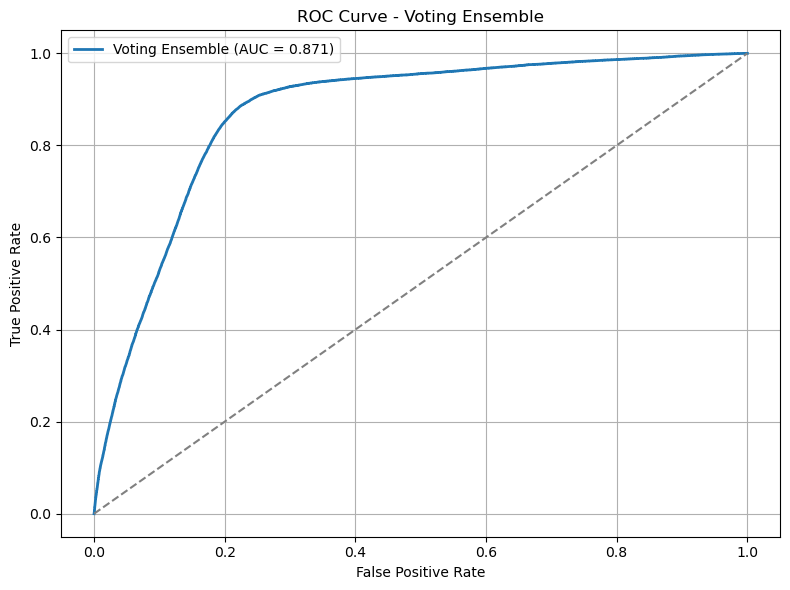

In [18]:
result_df_2, best_model = train_churn_model(df_train, target="churn")

In [19]:
print(result_df_2)

                Model  accuracy  precision    recall  f1_score
5      VotingEnsemble  0.814254   0.566341  0.838804  0.676156
1        RandomForest  0.807812   0.553816  0.867778  0.676127
3            LightGBM  0.822050   0.604532  0.665754  0.633668
0  LogisticRegression  0.777830   0.512095  0.824663  0.631836
4            CatBoost  0.819221   0.597134  0.670086  0.631510
2             XGBoost  0.821176   0.604111  0.657020  0.629456


In [20]:
df_test = engineer_features(df_test)
df_test = add_expected_tenure(df_test)
df_test = preprocess_data(df_test)

Columns scaled: 18
Remaining nulls: 0


In [21]:
# Use the expected_tenure prediction model you trained earlier
df_test["expected_tenure_pred"] = tenure_model.predict(df_test.drop(columns=["expected_tenure", "churn", "last_active"], errors="ignore"))

In [22]:
y_true = df_test["expected_tenure"]
y_pred = df_test["expected_tenure_pred"]

# Metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MAE: 2.3175
R²: 0.9391


In [23]:
exclude_cols = ["churn", "expected_tenure", "expected_tenure_pred", "last_active"]
X_test_final = df_test.drop(columns=[col for col in exclude_cols if col in df_test.columns])
y_test_final = df_test["churn"]

y_pred = best_model.predict(X_test_final)
y_proba = best_model.predict_proba(X_test_final)[:, 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86    120276
           1       0.55      0.87      0.68     35736

    accuracy                           0.81    156012
   macro avg       0.75      0.83      0.77    156012
weighted avg       0.86      0.81      0.82    156012



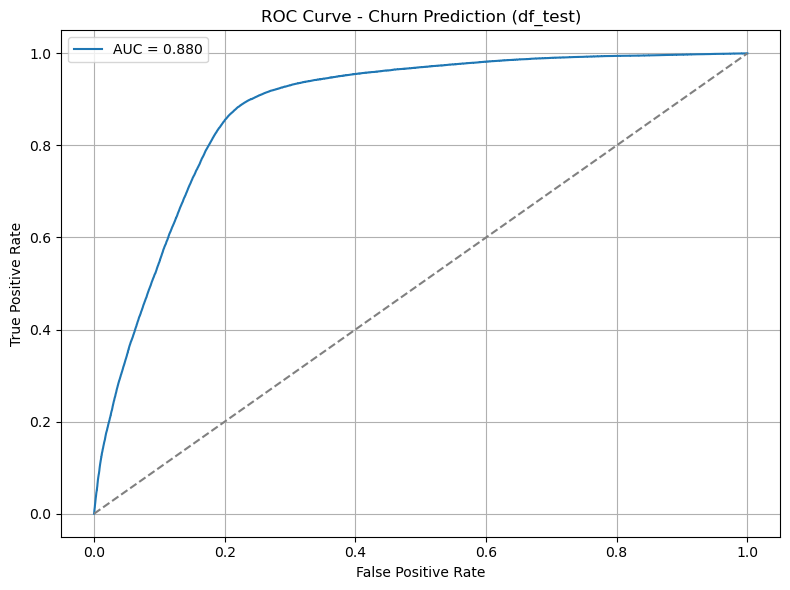

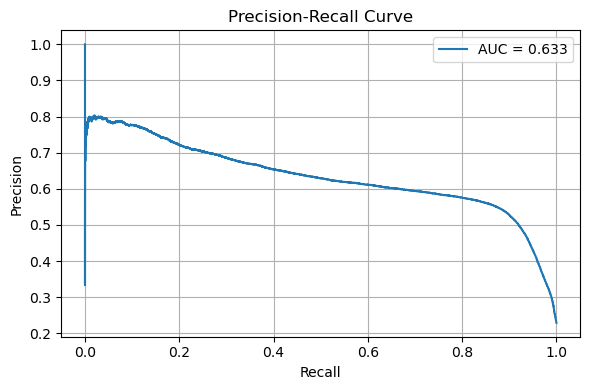

In [24]:
print("Classification Report:")
print(classification_report(y_test_final, y_pred))

fpr, tpr, _ = roc_curve(y_test_final, y_proba)
auc_score = roc_auc_score(y_test_final, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Churn Prediction (df_test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(y_test_final, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
def compare_churn_distribution(df_train, df_test):
    print("Churn Distribution:")
    print("Train Set:")
    print(df_train["churn"].value_counts(normalize=True), "\n")
    
    print("Test Set:")
    print(df_test["churn"].value_counts(normalize=True))
    
def compare_feature_means(df_train, df_test, important_features):
    train_means = df_train[important_features].mean()
    test_means = df_test[important_features].mean()
    
    mean_diff = pd.DataFrame({
        "Train Mean": train_means,
        "Test Mean": test_means,
        "Difference": train_means - test_means
    })
    return mean_diff

def plot_feature_distributions(df_train, df_test, features):
    for feature in features:
        plt.figure(figsize=(7, 4))
        sns.kdeplot(df_train[feature], label="Train", fill=True)
        sns.kdeplot(df_test[feature], label="Test", fill=True)
        plt.title(f"Distribution of '{feature}'")
        plt.legend()
        plt.tight_layout()
        plt.show()


🔹 Churn Distribution:
Train Set:
churn
0    0.768825
1    0.231175
Name: proportion, dtype: float64 

Test Set:
churn
0    0.770941
1    0.229059
Name: proportion, dtype: float64

Feature Mean Differences:

                        Train Mean     Test Mean    Difference
expected_tenure_pred  7.941437e+01  7.871603e+01  6.983374e-01
drop_trend            9.459511e-17  4.472431e-17  4.987080e-17
ema_30d              -1.402759e-17  4.654608e-17 -6.057366e-17
zero_days            -1.956575e-16  3.643529e-17 -2.320928e-16
total_usage           6.248652e-17  9.181692e-17 -2.933041e-17
usage_cv              4.317581e-17 -1.040410e-15  1.083585e-15


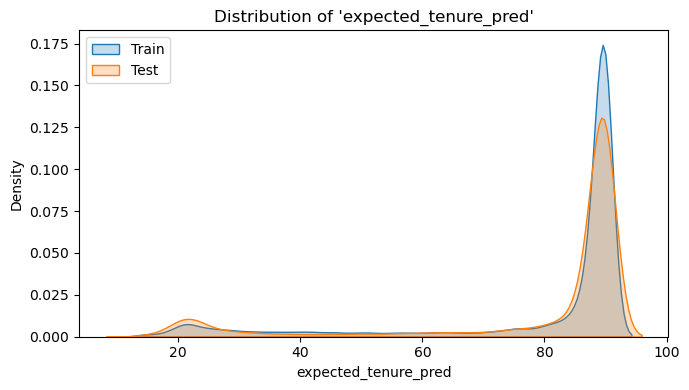

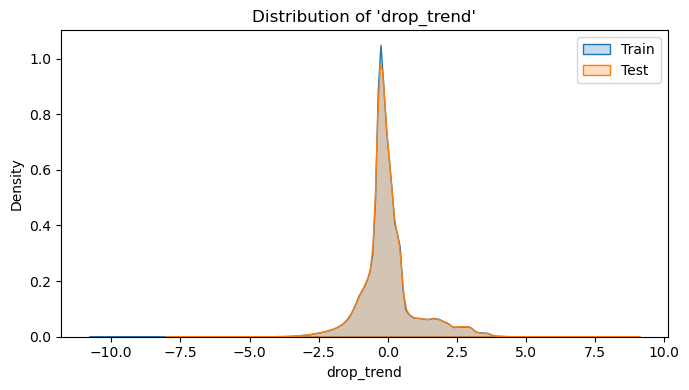

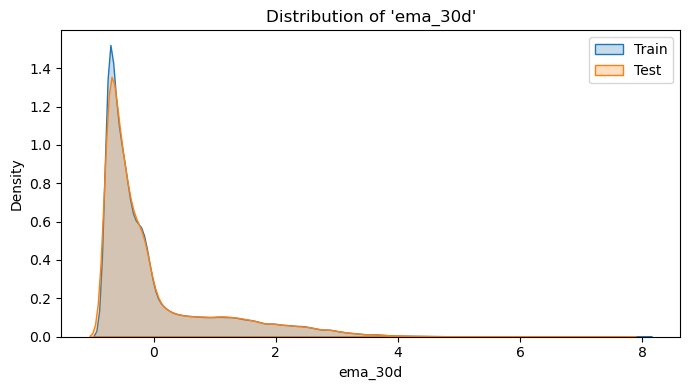

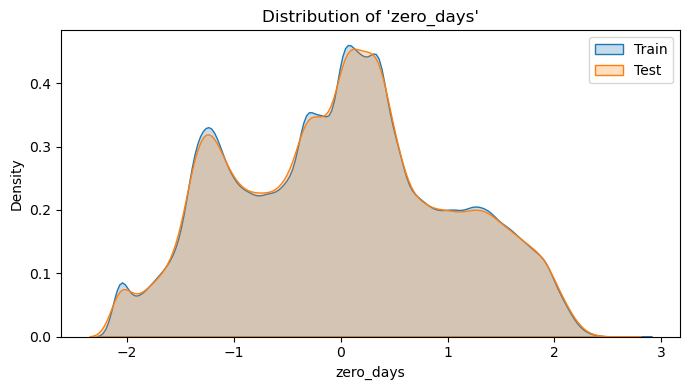

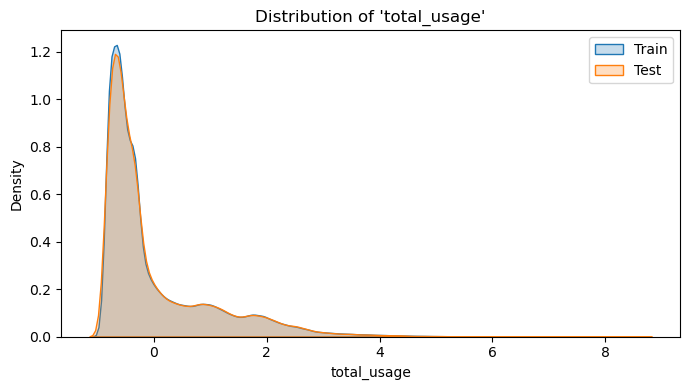

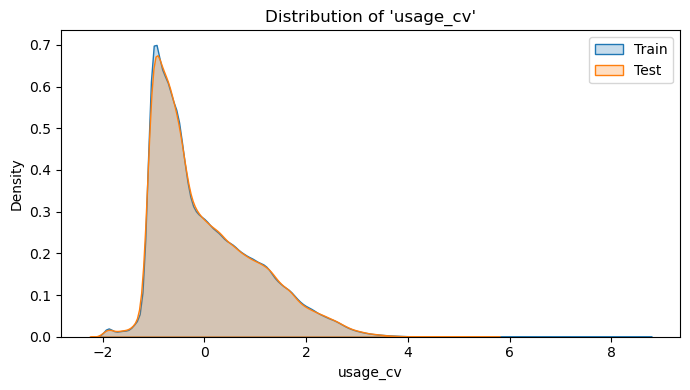

In [26]:
important_features = [
     "expected_tenure_pred","drop_trend", "ema_30d",
    "zero_days", "total_usage", "usage_cv"
]

compare_churn_distribution(df_train, df_test)

mean_diff_df = compare_feature_means(df_train, df_test, important_features)
print("\nFeature Mean Differences:\n")
print(mean_diff_df)

plot_feature_distributions(df_train, df_test, important_features)

In [27]:
# Saving both the Churn Prediction Model and Expected Tenure Prediction Model using JobLib:

joblib.dump(tenure_model, "expected_tenure_model.pkl")
joblib.dump(best_model, "churn_prediction_model.pkl")

['churn_prediction_model.pkl']

In [28]:
def plot_feature_importance(model, X, top_n=20):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = X.columns
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(10, 6))
        plt.title("Top Feature Importances", fontsize=16)
        plt.barh(range(top_n), importances[indices][::-1], align="center")
        plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
        plt.xlabel("Relative Importance")
        plt.tight_layout()
        plt.grid(True)
        plt.show()
    else:
        print("This model does not support feature_importances_ attribute.")

# Example usage:
# plot_feature_importance(best_model, X_train_final)

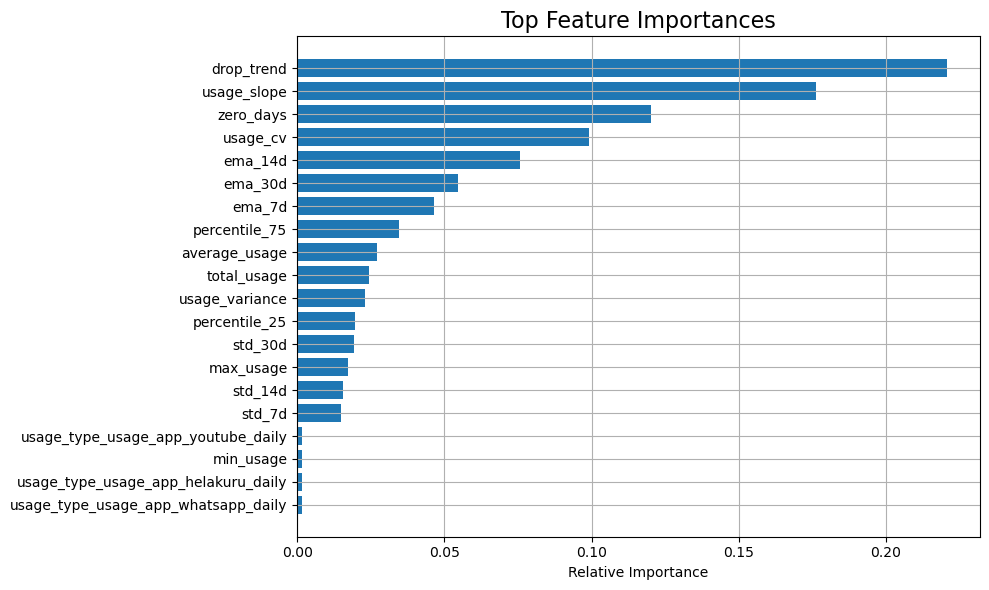

In [29]:
plot_feature_importance(best_model, X_test_final)

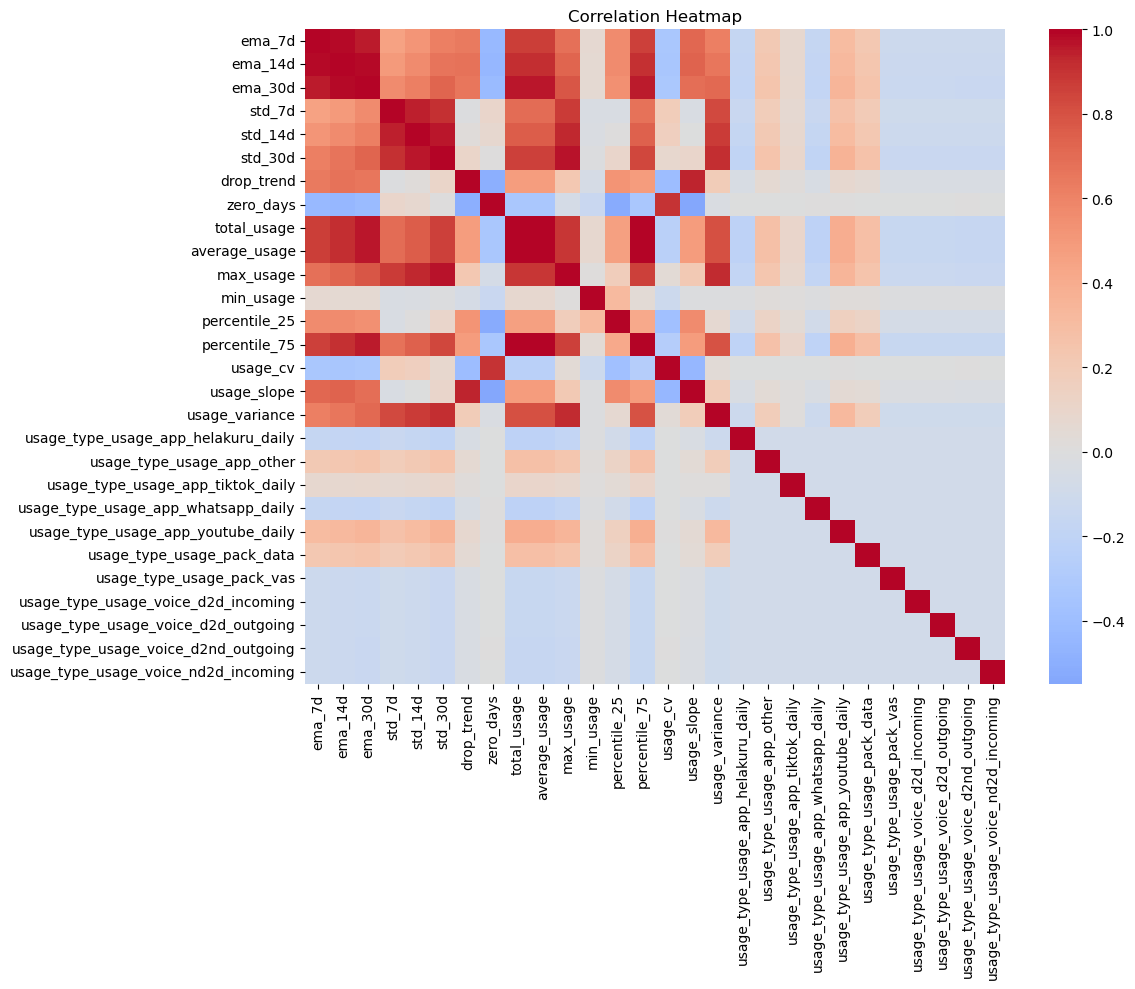

In [30]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_test_final.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

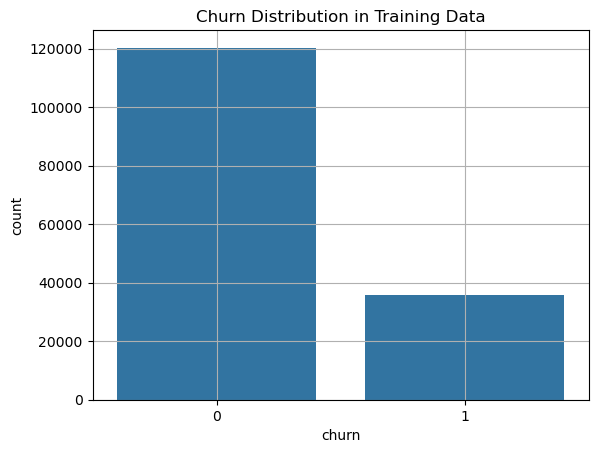

In [31]:
sns.countplot(x=y_test_final)
plt.title("Churn Distribution in Training Data")
plt.grid(True)
plt.show()


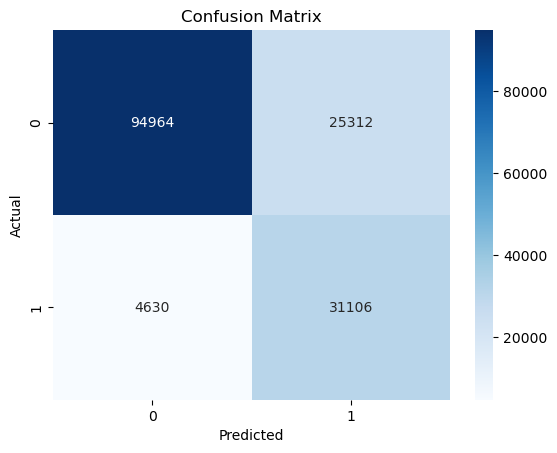

In [32]:
cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


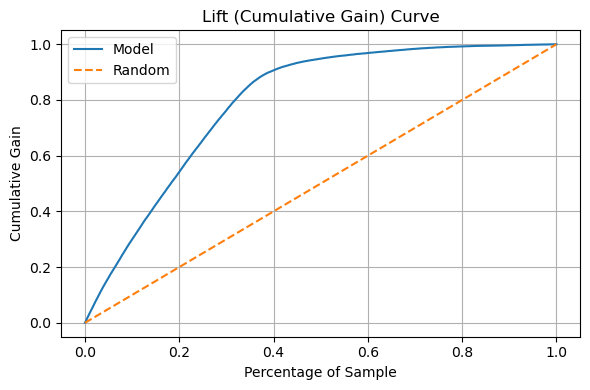

In [33]:
# Lift Chart (Cumulative Gain):

lift_df = pd.DataFrame({'y_true': y_test_final, 'y_prob': y_proba})
lift_df = lift_df.sort_values(by='y_prob', ascending=False)
lift_df['cumulative_gain'] = lift_df['y_true'].cumsum() / lift_df['y_true'].sum()
lift_df['percentage'] = np.arange(1, len(lift_df)+1) / len(lift_df)

plt.figure(figsize=(6, 4))
plt.plot(lift_df['percentage'], lift_df['cumulative_gain'], label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Gain")
plt.title("Lift (Cumulative Gain) Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The lift chart shows that the top 40% of users ranked by predicted churn probability account for over 90% of all churners, proving the model’s value for retention targeting.

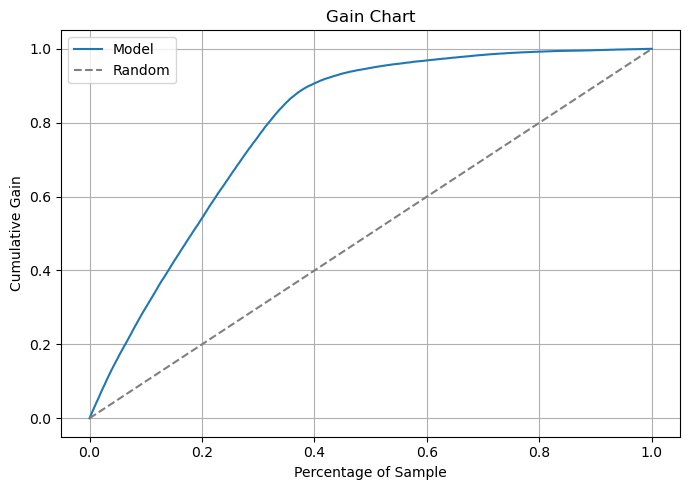

In [35]:
# Gain Chart:

def plot_gain_chart(y_true, y_proba):
    df = pd.DataFrame({"y_true": y_true, "y_proba": y_proba})
    df = df.sort_values("y_proba", ascending=False).reset_index(drop=True)
    df["cumulative_churn"] = df["y_true"].cumsum()
    df["gain"] = df["cumulative_churn"] / df["y_true"].sum()
    df["percentage"] = (df.index + 1) / len(df)

    plt.figure(figsize=(7, 5))
    plt.plot(df["percentage"], df["gain"], label="Model")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
    plt.title("Gain Chart")
    plt.xlabel("Percentage of Sample")
    plt.ylabel("Cumulative Gain")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_gain_chart(y_test_final, y_proba)

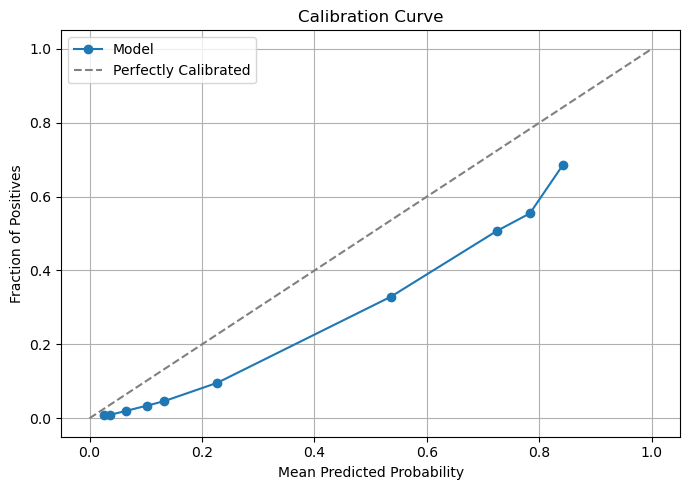

In [36]:
# Calibration Curve:

def plot_calibration_curve(y_true, y_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy='quantile')
    plt.figure(figsize=(7, 5))
    plt.plot(prob_pred, prob_true, marker='o', label="Model")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
    plt.title("Calibration Curve")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_calibration_curve(y_test_final, y_proba)

In [37]:
# Decile-Wise Lift Table:

def decile_lift_table(y_true, y_proba):
    df = pd.DataFrame({"y_true": y_true, "y_proba": y_proba})
    df["decile"] = pd.qcut(df["y_proba"], 10, labels=False)
    lift_table = df.groupby("decile").agg(
        total_customers=("y_true", "count"),
        churners=("y_true", "sum"),
    ).sort_index(ascending=False)
    lift_table["churn_rate"] = lift_table["churners"] / lift_table["total_customers"]
    lift_table["lift"] = lift_table["churn_rate"] / (df["y_true"].sum() / len(df))
    return lift_table

display(lift_df)

,y_true,y_prob,cumulative_gain,percentage
17911,1,0.940161,0.000028,0.000006
123097,0,0.939702,0.000028,0.000013
105828,0,0.938348,0.000028,0.000019
30109,1,0.938107,0.000056,0.000026
60656,0,0.934864,0.000056,0.000032
...,...,...,...,...
110958,0,0.007619,1.000000,0.999974
133436,0,0.007221,1.000000,0.999981
56567,0,0.006974,1.000000,0.999987
136893,0,0.006969,1.000000,0.999994


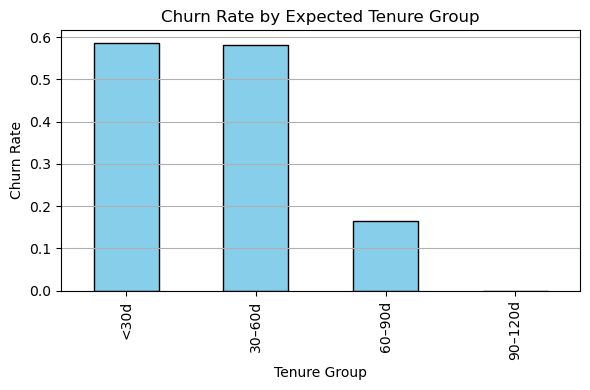

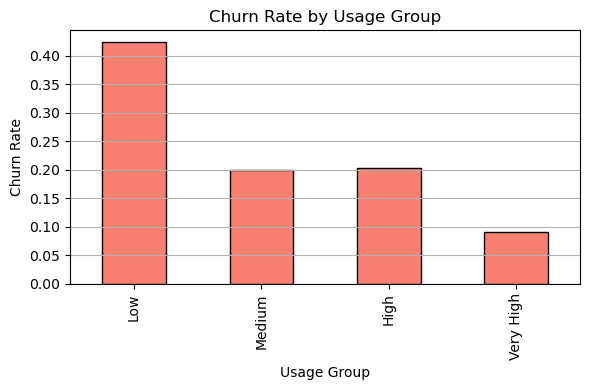

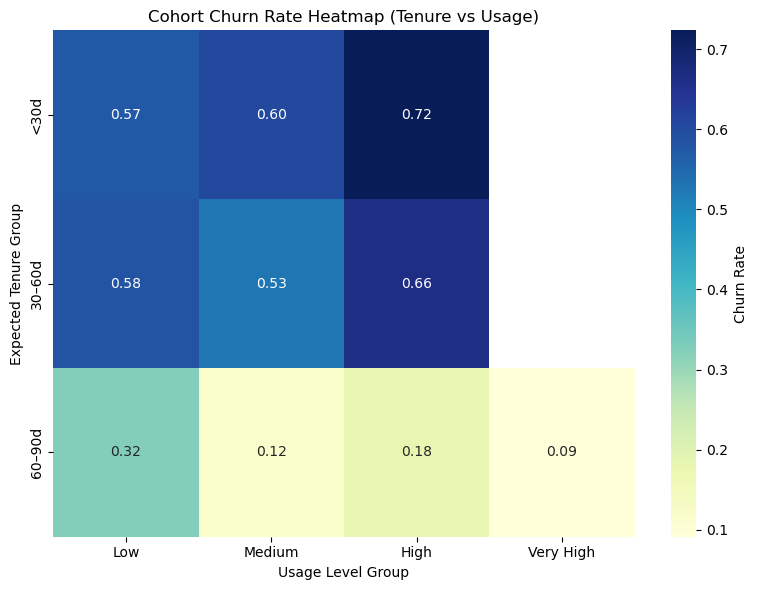

In [38]:
# Cohort Analysis:

df = df_test.copy()

# Create Expected Tenure Group
df['tenure_group'] = pd.cut(df['expected_tenure_pred'], bins=[0, 30, 60, 90, 120],
                            labels=['<30d', '30–60d', '60–90d', '90–120d'])

# Create Total Usage Quartile Group
df['usage_group'] = pd.qcut(df['total_usage'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Plot: Churn Rate by Tenure Group
plt.figure(figsize=(6, 4))
df.groupby('tenure_group')['churn'].mean().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Churn Rate by Expected Tenure Group')
plt.ylabel('Churn Rate')
plt.xlabel('Tenure Group')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot: Churn Rate by Usage Group
plt.figure(figsize=(6, 4))
df.groupby('usage_group')['churn'].mean().plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Churn Rate by Usage Group')
plt.ylabel('Churn Rate')
plt.xlabel('Usage Group')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Pivot table: Churn rate across cohorts
cohort_pivot = df.pivot_table(values='churn',
                               index='tenure_group',
                               columns='usage_group',
                               aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cohort_pivot, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Churn Rate'})
plt.title('Cohort Churn Rate Heatmap (Tenure vs Usage)')
plt.ylabel('Expected Tenure Group')
plt.xlabel('Usage Level Group')
plt.tight_layout()
plt.show()

**1. Tenure-Based Churn Behavior**

Users with expected tenure <30 days or 30–60 days have the highest churn rate (~57–58%).

Churn drastically drops for users with tenure 60–90 days, and is almost negligible beyond 90 days.

**Conclusion:**

Early-stage retention is critical. If a user survives beyond 60 days, they are much more likely to stay. Your retention strategies should focus on Day 0–60 users.

**2. Usage-Based Churn Behavior**

Churn rate is highest among low-usage users (~40%).

As usage increases, churn drops sharply, especially for Very High usage users (~10%).

Conclusion:

Usage frequency is a strong predictor of loyalty. Encourage consistent platform engagement to reduce churn. Consider gamification, usage nudges, or incentives for low-engagement users.

**3. Cohort Interaction: Tenure vs Usage Heatmap**

Users with <30 days tenure & high usage still churn heavily (~72%) → Red flag cohort.

Users with low tenure but medium/high usage show slightly better churn, but still risky (~60%+).

Users with 60–90 days tenure + high usage show lowest churn across the board (~9–18%).

**Conclusion:**

Merely increasing usage isn't enough for new users — they need value delivery + onboarding support. However, medium-long-term users with high usage are your gold mine — build loyalty programs here.

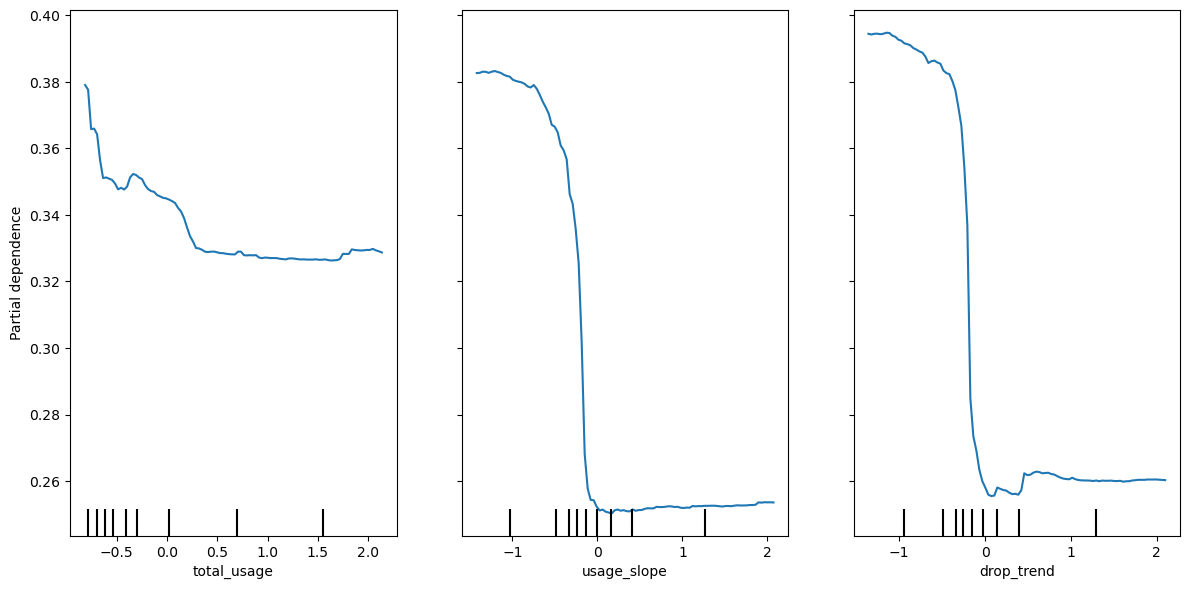

In [40]:
# Choose top features or specific feature names to visualize
features_to_plot = ["total_usage", "usage_slope", "drop_trend"]  # example

# Create PDP
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(best_model, X_test_final, features_to_plot, ax=ax)
plt.tight_layout()
plt.show()

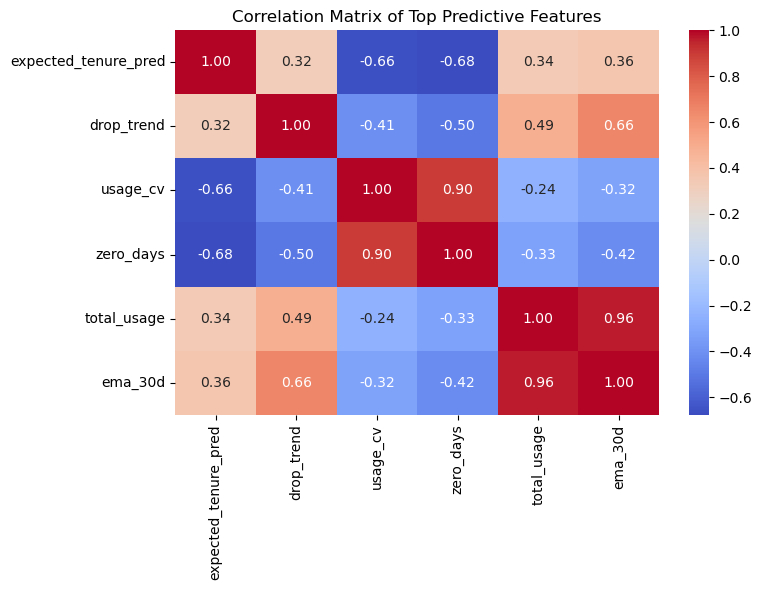

In [41]:
# Select top correlated features from df_test
top_features = ["expected_tenure_pred", "drop_trend", "usage_cv", "zero_days", "total_usage", "ema_30d"]
corr_matrix = df_test[top_features].corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Top Predictive Features")
plt.tight_layout()
plt.show()

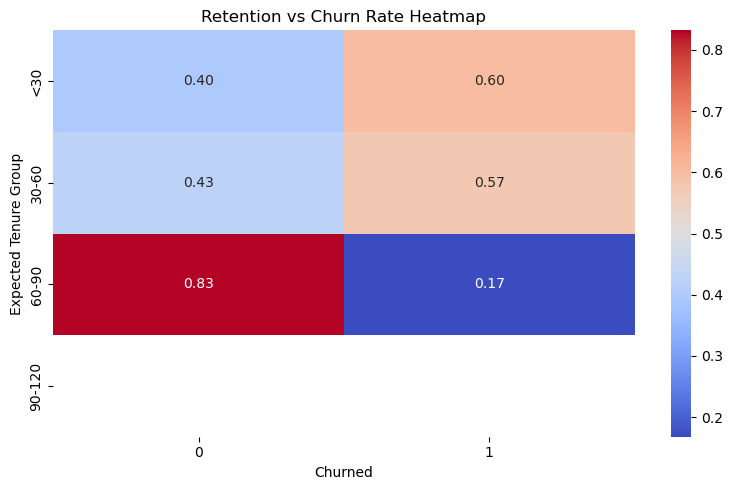

In [42]:
# Create retention categories
df_train['retention_bucket'] = pd.cut(
    df_train['expected_tenure_pred'], bins=[0, 30, 60, 90, 120], 
    labels=["<30", "30-60", "60-90", "90-120"]
)

# Group and calculate churn rate per retention bucket
retention_matrix = df_train.groupby(['retention_bucket', 'churn']).size().unstack().fillna(0)
retention_rate = retention_matrix.div(retention_matrix.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(retention_rate, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Retention vs Churn Rate Heatmap")
plt.xlabel("Churned")
plt.ylabel("Expected Tenure Group")
plt.tight_layout()
plt.show()


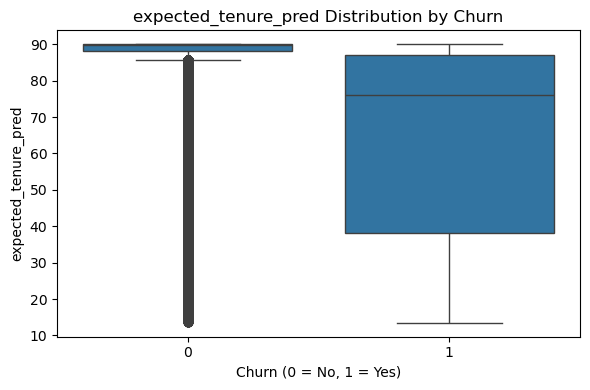

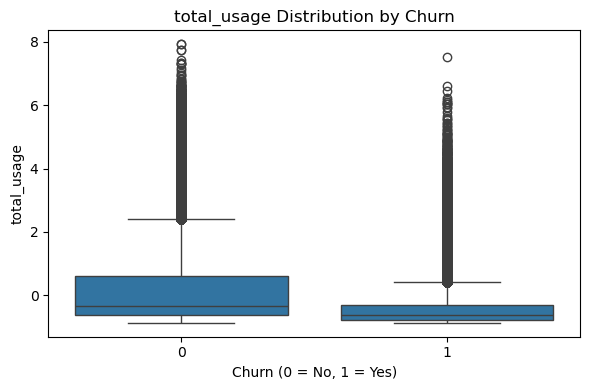

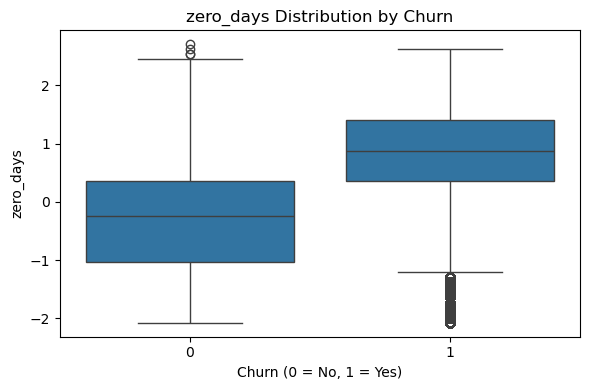

In [43]:
# Select top features to compare
features_to_plot = ["expected_tenure_pred", "total_usage", "zero_days"]

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_train, x="churn", y=feature)
    plt.title(f"{feature} Distribution by Churn")
    plt.xlabel("Churn (0 = No, 1 = Yes)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


In [45]:
# If 'churn' is encoded as 0 (no churn) and 1 (churn):
churn_percentage = df_train["churn"].mean() * 100
print(f"Churn Rate: {churn_percentage:.2f}%")

Churn Rate: 23.12%


In [46]:
# Predict churn on your test data
y_pred = best_model.predict(X_test_final)

# Calculate churn percentage in predictions
predicted_churn_percentage = np.mean(y_pred) * 100
print(f"Predicted Churn Rate on Test Data: {predicted_churn_percentage:.2f}%")


Predicted Churn Rate on Test Data: 36.16%


In [47]:
actual_churn_percentage = y_test_final.mean() * 100
print(f"Actual Churn Rate in Test Set: {actual_churn_percentage:.2f}%")


Actual Churn Rate in Test Set: 22.91%


In [48]:
print(f"Actual Churn:     {y_test_final.mean() * 100:.2f}%")
print(f"Predicted Churn:  {np.mean(y_pred) * 100:.2f}%")


Actual Churn:     22.91%
Predicted Churn:  36.16%


Text(0.5, 1.0, 'Actual vs Predicted Churn Rate')

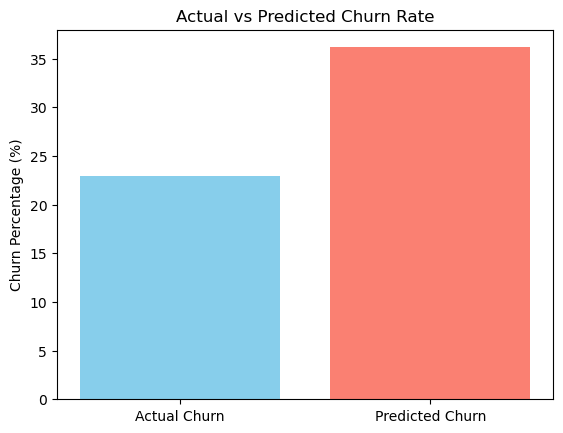

In [49]:
import matplotlib.pyplot as plt

plt.bar(["Actual Churn", "Predicted Churn"], [y_test_final.mean()*100, np.mean(y_pred)*100], color=["skyblue", "salmon"])
plt.ylabel("Churn Percentage (%)")
plt.title("Actual vs Predicted Churn Rate")


In [103]:
df_test.shape

(156012, 32)

In [105]:
df_train.shape

(624048, 33)